# Import Libraries

In [2]:
# numpy
import numpy as np

# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt

# Statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# sklearn 
from sklearn.metrics import mean_squared_error

# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
# Load dataset 
# 
data = pd.Series.from_csv(path='Data/robberies.csv', header=0)

# split dataset
split_point = len(data) - 12

# dataset (observation from year 1966 to 1974)
# validation_data (observations of year 1975)
dataset , validation_data = data[0:split_point], data[split_point:]

### Data Preparation: We have monthly dataset for 9 years (1966-1975), we split the dataset into two parts 
1- dataset (observation from year 1966 to 1974), will further split this into train and test. <br> 2- validation_data (observations of year 1975), will take this as a development set.

# Persistance Model (For Baseline RMSE)

In [4]:
# prepare data for persistence model

split_point = int(len(dataset) * 0.5)
train, test = dataset[0: split_point].values.astype('float32'), dataset[split_point:].values.astype('float32')

In [5]:
# walk-forward validation model
history = [i for i in train]

In [6]:
predictions = []
for i in range(len(test)):
    
    # get prediction
    y_pred = history[-1]
    predictions.append(y_pred)
    
    # observed
    y_true = test[i]
    history.append(y_true)
    print('Predicted: %.2f, Expected: %.3f' % (y_pred, y_true))
    
print('\nBaseline RMSE : %.2f' % (np.sqrt(mean_squared_error(test, predictions))))

Predicted: 98.00, Expected: 125.000
Predicted: 125.00, Expected: 155.000
Predicted: 155.00, Expected: 190.000
Predicted: 190.00, Expected: 236.000
Predicted: 236.00, Expected: 189.000
Predicted: 189.00, Expected: 174.000
Predicted: 174.00, Expected: 178.000
Predicted: 178.00, Expected: 136.000
Predicted: 136.00, Expected: 161.000
Predicted: 161.00, Expected: 171.000
Predicted: 171.00, Expected: 149.000
Predicted: 149.00, Expected: 184.000
Predicted: 184.00, Expected: 155.000
Predicted: 155.00, Expected: 276.000
Predicted: 276.00, Expected: 224.000
Predicted: 224.00, Expected: 213.000
Predicted: 213.00, Expected: 279.000
Predicted: 279.00, Expected: 268.000
Predicted: 268.00, Expected: 287.000
Predicted: 287.00, Expected: 238.000
Predicted: 238.00, Expected: 213.000
Predicted: 213.00, Expected: 257.000
Predicted: 257.00, Expected: 293.000
Predicted: 293.00, Expected: 212.000
Predicted: 212.00, Expected: 246.000
Predicted: 246.00, Expected: 353.000
Predicted: 353.00, Expected: 339.000
Pr

### Analysis (Persistance Model): 
We got RMSE value of <b>52.12 </b> which will act as a baseline value for improvement of ARIMA model.

# Data Analysis

## Summary Statistics

In [7]:
dataset.describe()

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: Robberies, dtype: float64

## Line Plot

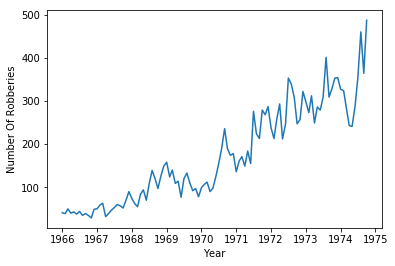

In [8]:
plt.plot(dataset)
plt.xlabel('Year')
plt.ylabel('Number Of Robberies')
plt.show()

### Analysis (Line Plot): Following observations can be made from above line plot
1- An increasing trend in observed from year to year. We will detrend it .<br>
2- Data is not stationary seems like it has varying mean and variance over time (years). We will remove seasonality .<br>
3- Large fluctions are observed from year to year. <br>
    * Earlier year posess less fluctuations .
    * Later years posess more fluctuations.

## Density Plot

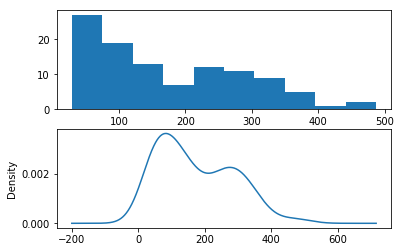

In [9]:
plt.figure(1)
plt.subplot(211)
plt.hist(dataset)
plt.subplot(212)
dataset.plot(kind='kde')
plt.show()

### Analysis (Density Plot): Following observations can be made from above Density plots
1- The histogram shows exponential distribution | long tailed towards right. This can be removed using log power transform. <br>
2- The density plot shows a bimodal distribution. <br>

## Box and Whisker Plot

In [10]:
# Groupby year
dataset_gp_byyear = dataset.groupby(pd.TimeGrouper('A'))

# Create a dataframe of groupby values
year = pd.DataFrame()
for date, monthly_values in dataset_gp_byyear:
    year[date.year] = monthly_values.values
    
# Plot Boxplot
year.boxplot()
plt.show()

ValueError: Length of values does not match length of index

### Analysis (Boxplot): 
#### Following observation can be made from above boxplot :
1- The yearwise change in distribution shows that trend may not be linear. <br>

# ARIMA MODEL

## First lets do a statistical stationarity test (ADF test) on the dataset

In [ ]:
# ADF test
result = adfuller(dataset)
print('p-value %.2f' % (result[1]))

### Analysis (ADF test): 
#### Following observation can be made from above p-value :
1- Given p-value of 0.99 seems like null hypothesis is accepted meaning that the data is not stationary and ARIMA model assumes data to be stationary lets first make it stationary <br>

In [ ]:
# Make dataset stationary by differencing
dataset_no_trend = pd.Series([ dataset[i]-dataset[i-1] for i in range(1, len(dataset))], index=dataset.index[1:])

In [ ]:
print('p-value after detrending : %f' % (adfuller(dataset_no_trend)[1]))

### Analysis (Post differencing): 
#### Following observation can be made from above p-value :
1- Given p-value of 0.000417 seems like null hypothesis is rejected meaning that the data is stationary and we can model ARIMA on it, suggesting 1-level differencing is required.<br>

## Find AR-MA parameters of ARIMA model using ACF and PACF plot

In [ ]:
plot_acf(dataset,lags=30)
plt.show()
plot_pacf(dataset, lags=30)
plt.show()

### Analysis (ACF And PACF): 
#### Following observation can be made from above plots :
1- From ACF plot it can be observed that lag uptill 10 shows great correlation so will consider value of p=10 hence its an AR(10) process. <br>
2- From PACF plot it can be observed that lag values uptill 2 so will consider value of q=2 hence its an MA(2) process. <br>
3- Since, we from the previous differencing part we found that d=1 makes the time series stationary, hence will take value of d=1. <br>

### ARIMA MODEL (Manually configured) - Walk Forward Style Validation

In [ ]:
def ARIMA_mannaul(order):
    
    history = [i for i in train]
    predictions = []
    
    for i in range(len(test)):
        
        # Fit model and predict
        model = ARIMA(history, order=order)
        
        try : 
            y_pred = model.fit(disp=0).forecast()[0]
            
        except: 
            pass
    
        predictions.append(y_pred)
        
        # y_true
        y_true = test[i]
        history.append(y_true)
#         print('Predicted : %.2f , Observed : %.2f' % (y_pred, y_true))
        
    # Model performance
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Result RMSE: %.2f when p:%s, d:%s and q:%s' % (rmse, order[0], order[1], order[2]))
    
    return rmse

In [ ]:
# ARIMA mannual configuration(1) p=10, d=1 and q=2
rmse_cfg_1 =ARIMA_mannaul(order=(10,1,2))

### Analysis (ARIMA Mannually Configuration-(1)): 
#### From the following predicted results using configuration(1) it can be observed that:
With some more validation using different values of (p,d,q) the model is not able to converge with non-zero values of AR and MA at the same time and results in error by the underlying library. <br>
So, will test out different confgurations of the model while one of the values of p or q is 0.

In [ ]:
# ARIMA mannual configuration(2) p=0, d=1 and q=2
rmse_cfg_2 = ARIMA_mannaul(order=(0,1,2))

In [ ]:
# ARIMA mannual configuration(3) p=10, d=1 and q=0
rmse_cfg_3 = ARIMA_mannaul(order=(10,1,0))

### Analysis (ARIMA Mannually Configuration-(2) and (3)): 
#### From the following predicted results using configuration(2) and configuration(3) it can be observed that
Testing out different confguration-(2) and (3) of the model while one of the values of p or q is 0, shows improvement on RMSE over base persistence model.

### GRID search ARIMA Model
Will search parameters of ARIMA model using different values of p-(0 to 12), d-(0 to 3), q-(0 to 12)

In [ ]:
def evaluate_arima_model(train, test, order):
    
    eval_history = [i for i in train]
    
    eval_predictions = []
    
    for i in range(len(test)):
        
        # Fit model and predict
        model = ARIMA(history, order=order)
        
        try:
            y_pred = model.fit(disp=0).forecast()[0]
        except:
            pass
        
        eval_predictions.append(y_pred)
        
        # Get y_true
        y_true = test[i]
        history.append(y_true)
        
    # Model performance
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Result RMSE: %.2f when p:%s, d:%s and q:%s' % (rmse, order[0], order[1], order[2]))  

In [ ]:
# Function for grid search
def grid_ARIMA(p_values, d_values, q_values):
    
    best_rmse, best_cfg = float('inf'), None
    
    for i in p_values:
        for j in d_values:
            for k in q_values:                    
                
                grid_rmse = evaluate_arima_model(train, test, (i,j,k))
                
                if grid_rmse < best_rmse:
                    best_score, best_cfg = grid_rmse, (i,j,k)
                print('Got RMSE: %.2f ARIMA CFG : p:%s, d:%s and q:%s' % (grid_rmse, i,j,k))
                
    print('Best RMSE: %.2f ARIMA CFG : p:%s, d:%s and q:%s' % (best_score, best_cfg[0], best_cfg[1], best_cfg[2]))
                

In [ ]:
# Define parameters p, d and q
p = np.arange(0, 13)
d = np.arange(0, 4)
q = np.arange(0, 13)

In [ ]:
# Apply grid search on ARIMA
grid_ARIMA(p,d,q)